In [1]:
import os
import numpy as np
import h5py
import glob
import itertools
import sys
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim

import random
import generatorIN
from generatorIN import InEventLoader
import time
args_cuda = bool(sys.argv[2])


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../python/sonic.mplstyle')

In [3]:
# define the pytorch model
class GraphNet(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De, Do,
                 fr_activation=0, fo_activation=0, fc_activation=0, optimizer = 0, verbose = False):
        super(GraphNet, self).__init__()
        self.hidden = hidden
        self.P = len(params)
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.n_targets = n_targets
        self.fr_activation = fr_activation
        self.fo_activation = fo_activation
        self.fc_activation = fc_activation
        self.optimizer = optimizer
        self.verbose = verbose
        self.assign_matrices()

        self.Ra = torch.ones(self.Dr, self.Nr)

        self.fr1 = nn.Linear(2 * self.P + self.Dr, hidden)
        self.fr2 = nn.Linear(hidden, int(hidden/2))
        self.fr3 = nn.Linear(int(hidden/2), self.De)
        self.fo1 = nn.Linear(self.P + self.Dx + self.De, hidden)
        self.fo2 = nn.Linear(hidden, int(hidden/2))
        self.fo3 = nn.Linear(int(hidden/2), self.Do)
        self.fc1 = nn.Linear(self.Do * self.N, hidden)
        self.fc2 = nn.Linear(hidden, int(hidden/2))
        self.fc3 = nn.Linear(int(hidden/2), self.n_targets)

    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
            self.Rr = Variable(self.Rr)
            self.Rs = Variable(self.Rs)            
            
    def forward(self, x):
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###                                                                                               
        B = torch.transpose(B, 1, 2).contiguous()
        if self.fr_activation ==2:
            B = nn.functional.selu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.selu(self.fr2(B))
            E = nn.functional.selu(self.fr3(B).view(-1, self.Nr, self.De))
        elif self.fr_activation ==1:
            B = nn.functional.elu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.elu(self.fr2(B))
            E = nn.functional.elu(self.fr3(B).view(-1, self.Nr, self.De))
        else:
            B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.relu(self.fr2(B))
            E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        C = torch.cat([x, Ebar], 1)
        del Ebar
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###                                                                                              
        if self.fo_activation ==2:
            C = nn.functional.selu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.selu(self.fo2(C))
            O = nn.functional.selu(self.fo3(C).view(-1, self.N, self.Do))
        elif self.fo_activation ==1:
            C = nn.functional.elu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.elu(self.fo2(C))
            O = nn.functional.elu(self.fo3(C).view(-1, self.N, self.Do))
        else:
            C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.relu(self.fo2(C))
            O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C
        ### Classification MLP ###                                                                                      
        if self.fc_activation ==2:
            N = nn.functional.selu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.selu(self.fc2(N))
        elif self.fc_activation ==1:
            N = nn.functional.elu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.elu(self.fc2(N))
        else:
            N = nn.functional.relu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.relu(self.fc2(N))
        #del O
        #N = nn.functional.relu(self.fc3(N))                                                                            
        N = self.fc3(N)
        return N, O

    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L                                                       
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.reshape(-1, x_shape[2]), y).reshape(-1, x_shape[1], y_shape[1])

In [4]:
def get_sample(training, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 50000)
    return training[chosen_ind], target[chosen_ind]


In [5]:
def accuracy(predict, target):
    _, p_vals = torch.max(predict, 1)
    r = torch.sum(target == p_vals.squeeze(1)).data.numpy()[0]
    t = target.size()[0]
    return r * 1.0 / t

In [6]:
def stats(predict, target):
    print(predict)
    _, p_vals = torch.max(predict, 1)
    t = target.cpu().data.numpy()
    p_vals = p_vals.squeeze(1).data.numpy()
    vals = np.unique(t)
    for i in vals:
        ind = np.where(t == i)
        pv = p_vals[ind]
        correct = sum(pv == t[ind])
        print("  Target %s: %s/%s = %s%%" % (i, correct, len(pv), correct * 100.0/len(pv)))
    print("Overall: %s/%s = %s%%" % (sum(p_vals == t), len(t), sum(p_vals == t) * 100.0/len(t)))
    return sum(p_vals == t) * 100.0/len(t)

In [7]:
nGraphVtx = 30
hidden_nodes = 20
De = 3
Do = 5

In [8]:
#####
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']  # this is a classifier
params = ['j1_px', 'j1_py' , 'j1_pz' , 'j1_e' , 'j1_erel' , 'j1_pt' , 'j1_ptrel', 'j1_eta' , 'j1_etarel' , 
          'j1_etarot' , 'j1_phi' , 'j1_phirel' , 'j1_phirot', 'j1_deltaR' , 'j1_costheta' , 'j1_costhetarel'] # these are the features in the graph

val_split = 0.3
batch_size = 100
n_epochs = 100
patience = 10

In [9]:
nParticles = 30

In [15]:
import glob
#### LIST OF TRAINING FILES
inputTrainFiles = glob.glob("../data2/Training/jetImage*_%sp*.h5" %nParticles)
#### LIST OF VALIDATION FILES
inputValFiles = glob.glob("../data2/Validation/jetImage*_%sp*.h5" %nParticles)

mymodel = GraphNet(nGraphVtx, len(labels), params, hidden_nodes, De, Do, 0)

In [16]:
inputValFiles

['../data2/Validation\\jetImage_7_30p_0_10000.h5',
 '../data2/Validation\\jetImage_7_30p_10000_20000.h5',
 '../data2/Validation\\jetImage_7_30p_20000_30000.h5',
 '../data2/Validation\\jetImage_7_30p_30000_40000.h5',
 '../data2/Validation\\jetImage_7_30p_40000_50000.h5',
 '../data2/Validation\\jetImage_7_30p_50000_60000.h5',
 '../data2/Validation\\jetImage_7_30p_60000_70000.h5',
 '../data2/Validation\\jetImage_7_30p_70000_80000.h5',
 '../data2/Validation\\jetImage_7_30p_80000_90000.h5',
 '../data2/Validation\\jetImage_8_30p_0_10000.h5',
 '../data2/Validation\\jetImage_8_30p_10000_20000.h5',
 '../data2/Validation\\jetImage_8_30p_20000_30000.h5',
 '../data2/Validation\\jetImage_8_30p_30000_40000.h5',
 '../data2/Validation\\jetImage_8_30p_40000_50000.h5',
 '../data2/Validation\\jetImage_8_30p_50000_60000.h5',
 '../data2/Validation\\jetImage_8_30p_60000_70000.h5',
 '../data2/Validation\\jetImage_8_30p_70000_80000.h5',
 '../data2/Validation\\jetImage_8_30p_80000_90000.h5',
 '../data2/Validat

In [17]:
loss = nn.CrossEntropyLoss(reduction='mean')
if mymodel.optimizer == 1:        
    optimizer = optim.Adadelta(mymodel.parameters(), lr = 0.0001)
else:
    optimizer = optim.Adam(mymodel.parameters(), lr = 0.0001)

In [18]:
loss_train = np.zeros(n_epochs)
loss_val = np.zeros(n_epochs)
nBatches_per_training_epoch = len(inputTrainFiles)*10000/batch_size
nBatches_per_validation_epoch = len(inputValFiles)*10000/batch_size
print("nBatches_per_training_epoch: %i" %nBatches_per_training_epoch)
print("nBatches_per_validation_epoch: %i" %nBatches_per_validation_epoch)

nBatches_per_training_epoch: 6100
nBatches_per_validation_epoch: 2700


In [19]:
for i in range(n_epochs):
    print(i)
    start = time.time()
    if mymodel.verbose: print("Epoch %s" % i)
    # Define the data generators from the training set and validation set.
    random.shuffle(inputTrainFiles)
    random.shuffle(inputValFiles)
    train_set = InEventLoader(file_names=inputTrainFiles, nP=nParticles,
                              feature_name ='jetConstituentList',label_name = 'jets', verbose=False)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_set = InEventLoader(file_names=inputValFiles, nP=nParticles,
                            feature_name ='jetConstituentList',label_name = 'jets', verbose=False)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    ####
    # train
    for batch_idx, mydict in enumerate(train_loader):
        data = mydict['jetConstituentList']
        target = mydict['jets']
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        out, hidden = mymodel(data)
        l = loss(out, target)
        l.backward()
        optimizer.step()
        loss_train[i] += l.cpu().data.numpy()/nBatches_per_training_epoch
    # validation
    for batch_idx, mydict in enumerate(val_loader):
        data = mydict['jetConstituentList']
        target = mydict['jets']
        data, target = Variable(data, volatile=True), Variable(target)
        out_val, hidden = mymodel(data)
        l_val = loss(out_val, target)
        loss_val[i] += l_val.cpu().data.numpy()/nBatches_per_validation_epoch
    if mymodel.verbose: print("Training   Loss: %f" %loss_train[i])
    if mymodel.verbose: print("Validation Loss: %f" %loss_val[i])
    if all(loss_val[max(0, i - patience):i] > min(np.append(loss_val[0:max(0, i - patience)], 200))) and i > patience:
        print("Early Stopping")
        break
    stop = time.time()
    duration = start - stop
    print(duration)
    

0


C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\ipykernel_launcher.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


-591.9415464401245
1
-589.1462750434875
2
-593.0559253692627
3
-587.2313628196716
4
-588.4183833599091
5
-588.6655759811401
6
-587.3694446086884
7
-586.3083295822144
8
-588.6184778213501
9
-584.8485524654388
10
-588.652428150177
11
-590.1374554634094
12
-589.5153353214264
13
-588.4204804897308
14
-590.5114240646362
15
-588.3120765686035
16
-588.4297132492065
17
-588.9287419319153
18
-590.6223244667053
19
-590.6311829090118
20
-589.5224757194519
21
-588.9024739265442
22
-591.7463717460632
23
-584.9712269306183
24
-587.233490228653
25
-587.4393131732941
26
-586.914617061615
27
-587.1164996623993
28
-585.9521725177765
29
-585.7792725563049
30
-588.2008759975433
31
-587.6262068748474
32
-587.7040827274323
33
-586.7208042144775
34
-589.1484620571136
35
-587.5872294902802
36
-583.9473302364349
37
-584.9567441940308
38
-584.7933151721954
39
-587.6424572467804
40
-586.7058408260345
41
-584.7669105529785
42
-587.5474212169647
43
-589.5691204071045
44
-587.7401401996613
45
-587.261415719986
46
-

In [20]:
import h5py
f = h5py.File("secondtryhistory.h5", "w")
f.create_dataset('train_loss', data= np.asarray(loss_train), compression='gzip')
f.create_dataset('val_loss', data= np.asarray(loss_val), compression='gzip')

# the best model
torch.save(mymodel.state_dict(), 'C:/Users/anrun/JEDInet-code/models/newLONGbest_model.params')


In [21]:
finalloss=[]
models=[]
models.append(mymodel)
loss_val = loss_val[loss_val>0]
finalloss.append(loss_val[-1])

In [33]:
mymodel.load_state_dict(torch.load("../models/newLONGbest_model.params", map_location='cpu'))
mymodel.eval()

GraphNet(
  (fr1): Linear(in_features=32, out_features=20, bias=True)
  (fr2): Linear(in_features=20, out_features=10, bias=True)
  (fr3): Linear(in_features=10, out_features=3, bias=True)
  (fo1): Linear(in_features=19, out_features=20, bias=True)
  (fo2): Linear(in_features=20, out_features=10, bias=True)
  (fo3): Linear(in_features=10, out_features=5, bias=True)
  (fc1): Linear(in_features=150, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
)

In [34]:
#read datasets
X = np.array([])                                                                                                                                      
Y = np.array([]) 
Y_hlf = np.array([]) 
for fileIN in inputValFiles:
    if X.shape[0] >10000: continue
    f = h5py.File(fileIN, 'r')                                                                                                                        
    myFeatures = np.array(f.get('jetConstituentList'))                                                                                                
    myTarget = np.array(f.get('jets')[0:,-6:-1])
    myHLF = np.array(f.get('jets'))
    X = np.concatenate([X,myFeatures], axis = 0) if X.size else myFeatures                                                                            
    Y = np.concatenate([Y,myTarget], axis = 0) if Y.size else myTarget                                                                                
    Y_hlf = np.concatenate([Y_hlf,myHLF], axis = 0) if Y_hlf.size else myHLF                                                                                
    print(X.shape, Y.shape, Y_hlf.shape)

(10000, 30, 16) (10000, 5) (10000, 59)
(20000, 30, 16) (20000, 5) (20000, 59)


In [35]:
# pre-processing                                                                                                                                
X, Y, Y_hlf = shuffle(X, Y, Y_hlf, random_state=1)
X = np.swapaxes(X, 1, 2)
#Y = np.argmax(Y, axis=1)
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)
Y_hlf = torch.FloatTensor(Y_hlf)

In [36]:
# extract the O matrix and the category output [TBF]
predict_test = []
lst = []
Otot = []
for j in torch.split(X, batch_size):
    a, myO = mymodel(j)
    a = a.cpu().data.numpy()
    myO = myO.cpu().data.numpy()
    # sum over particles
    lst.append(a)
    Otot.append(myO)
    
predicted = Variable(torch.FloatTensor(np.concatenate(lst)))
predicted = torch.nn.functional.softmax(predicted, dim=1)
predict_test = predicted.data.numpy()

O_predicted = Variable(torch.FloatTensor(np.concatenate(Otot)))
O_predicted_test = O_predicted.data.numpy()

j_g tagger, auc = 91.9%
j_q tagger, auc = 91.5%
j_w tagger, auc = 95.6%
j_z tagger, auc = 94.8%
j_t tagger, auc = 95.8%


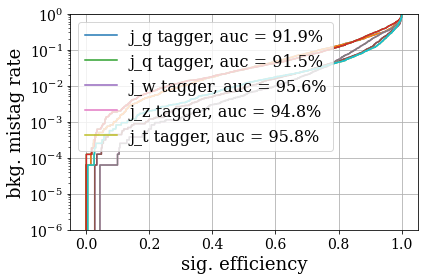

In [37]:
# ROC CURVE
import pandas as pd
from sklearn.metrics import roc_curve, auc
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        df[label] = Y[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
        print('%s tagger, auc = %.1f%%' %(label,auc1[label]*100.))
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%' %(label,auc1[label]*100.))
        plt.plot(tpr[label],fpr[label])
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='upper left')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

In [38]:
# HLF  in classifier
myHLFlist = [12, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 52]
namesY = ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 
          'd2_b1_mmdt', 'd2_b2_mmdt','d2_a1_b2_mmdt', 'm2_b1_mmdt', 
          'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
labelsY = ['$\Sigma zlog(z)$', '$C_{1}^{0}$', '$C_{1}^{1}$', '$C_{1}^{2}$',
          '$C_{2}^{1}$', '$C_{2}^{2}$',
         '$D_{2}^{1}$','$D_{2}^{2}$',
          '$D_{2}^{(1,2)}$', 
         '$M_{2}^{1}$', '$M_{2}^{2}$',
         '$N_{2}^{1}$', '$N_{2}^{2}$', 'jet $m_{mMDT}$', 'Multiplicity']


In [39]:
# other HLF: all
myHLFlist = [4,26,7,29,
             5,27,8,30,
             6,28,9,31]
namesY = ['j_tau1_b1', 'j_tau1_b1_mmdt','j_tau1_b2',  'j_tau1_b2_mmdt', 
          'j_tau2_b1', 'j_tau2_b1_mmdt','j_tau2_b2',  'j_tau2_b2_mmdt', 
          'j_tau3_b1', 'j_tau3_b1_mmdt','j_tau3_b2',  'j_tau3_b2_mmdt']
labelsY = ['$\\tau_1^1$','$\\tau_1^{1,mmdt}$','$\\tau_1^2$','$\\tau_1^{2,mmdt}$',
           '$\\tau_2^1$','$\\tau_2^{1,mmdt}$','$\\tau_2^2$','$\\tau_2^{2,mmdt}$',
           '$\\tau_3^1$','$\\tau_3^{1,mmdt}$','$\\tau_3^2$','$\\tau_3^{2,mmdt}$']

In [40]:
# other HLF: w/o mmdt 
myHLFlist = [4,7,
             5,8,
             6,9]
namesY = ['j_tau1_b1', 'j_tau1_b2',  
          'j_tau2_b1', 'j_tau2_b2', 
          'j_tau3_b1', 'j_tau3_b2']
labelsY = ['$\\tau_1^1$','$\\tau_1^2$',
           '$\\tau_2^1$','$\\tau_2^2$',
           '$\\tau_3^1$','$\\tau_3^2$']

In [41]:
# other HLF: with mmdt 
myHLFlist = [26,29,
             27,30,
             28,31]
namesY = ['j_tau1_b1_mmdt', 'j_tau1_b2_mmdt',  
          'j_tau2_b1_mmdt', 'j_tau2_b2_mmdt', 
          'j_tau3_b1_mmdt', 'j_tau3_b2_mmdt']
labelsY = ['$\\tau_1^{1,mmdt}$','$\\tau_1^{2,mmdt}$',
           '$\\tau_2^{1,mmdt}$','$\\tau_2^{2,mmdt}$',
           '$\\tau_3^{1,mmdt}$','$\\tau_3^{2,mmdt}$']

In [42]:
k = 0

In [51]:
f = h5py.File("secondtryhistory.h5", "r")

In [52]:
f.keys()

<KeysViewHDF5 ['train_loss', 'val_loss']>

In [53]:
treeArray = f['train_loss'][()] #Empty tuple indexing retrieves all values
print(treeArray.dtype.names)

None


In [54]:
treeArray2 = f['val_loss'][()]

In [55]:
y = []
for x in range (0,100):
    y.append(x)


In [56]:
np.shape(y)

(100,)

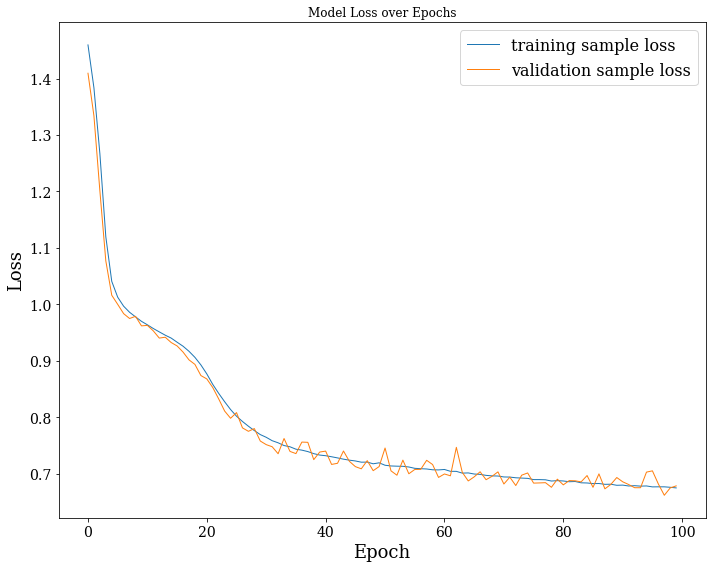

In [57]:

plt.figure(figsize=(10,8))
plt.plot(treeArray, linewidth=1)
plt.plot(treeArray2, linewidth=1)
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()